In [1]:
import pandas as pd
from sklearn import datasets

wine_data = datasets.load_wine()
df_wine = pd.read_csv('data/heart.csv')
# df_wine = pd.DataFrame(csv,columns=csv.feature_names)

In [2]:
from sklearn.model_selection import train_test_split

X = df_wine.drop(['output'], axis=1)
y = df_wine['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Permutation Importance

In [3]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge

model = Ridge(alpha=1e-2).fit(X_train, y_train)
r = permutation_importance(model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_wine.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


cp      0.150 +/- 0.047
caa     0.084 +/- 0.039
sex     0.069 +/- 0.033
exng    0.057 +/- 0.024
thalachh0.043 +/- 0.019


SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


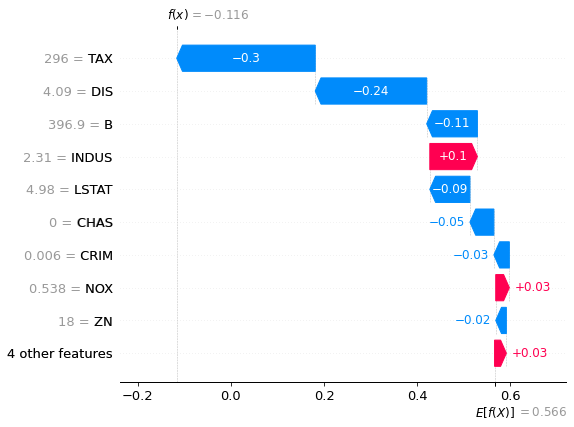

In [4]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

Yellowbrick
Таблица корреляции

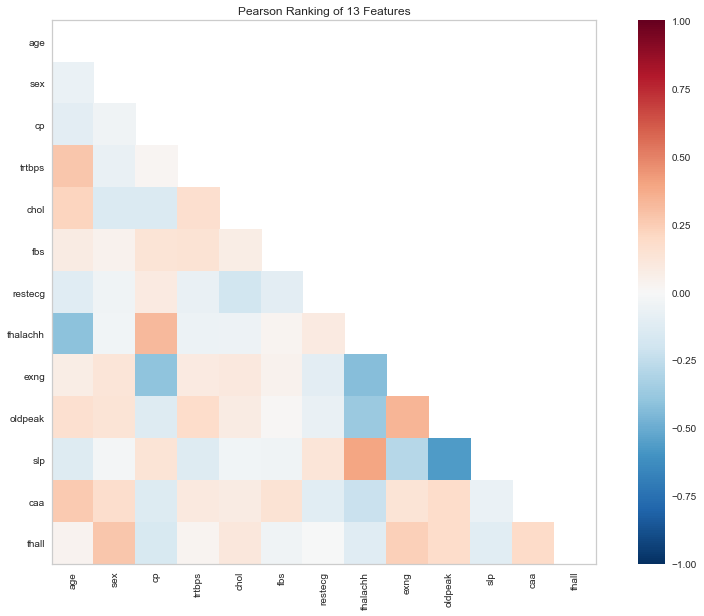

<AxesSubplot:title={'center':'Pearson Ranking of 13 Features'}>

In [5]:
from yellowbrick.features import Rank2D
import matplotlib.pyplot as plt
visualizer = Rank2D(algorithm="pearson",  size=(1080, 720))
visualizer.fit_transform(X_train)
visualizer.poof()

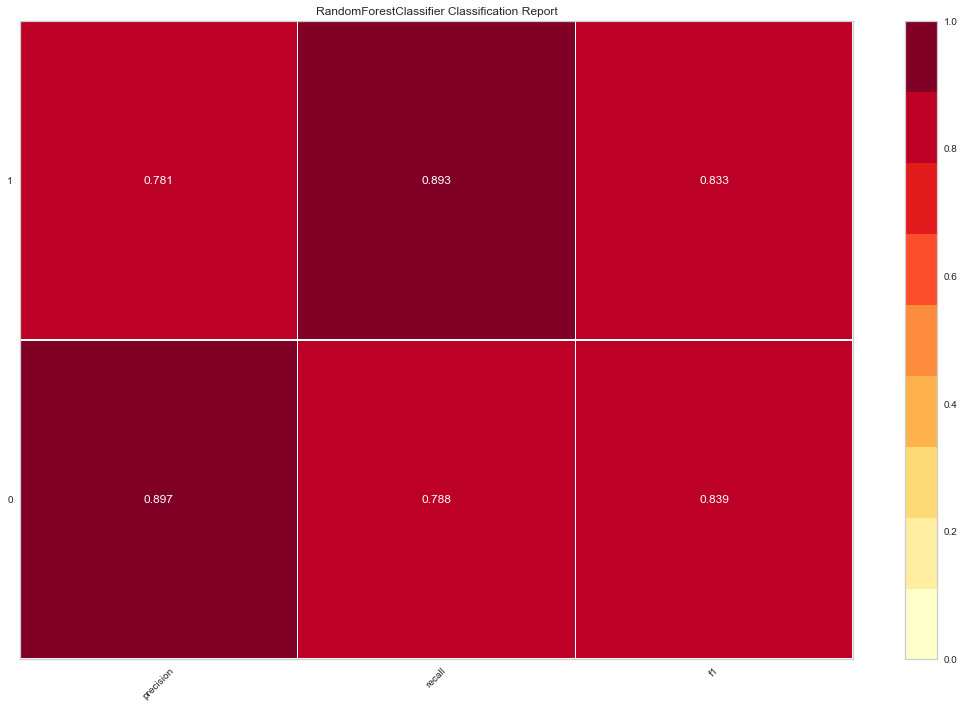

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [6]:
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier
model =  RandomForestClassifier()
visualizer = ClassificationReport(model, size=(1080, 720))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

ELI5

In [7]:
import eli5
eli5.show_weights(model, feature_names = X.columns.tolist())

Weight,Feature
0.1356 ± 0.1822,DIS
0.1214 ± 0.1537,B
0.1132 ± 0.1757,INDUS
0.1021 ± 0.1383,TAX
0.0980 ± 0.1583,LSTAT
0.0904 ± 0.0959,CRIM
0.0795 ± 0.0739,NOX
0.0658 ± 0.0727,CHAS
0.0606 ± 0.1338,RAD
0.0530 ± 0.1109,PTRATIO


In [8]:
from eli5 import show_prediction
show_prediction(model, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

LIME

In [9]:
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(), class_names=y_train.unique())

In [10]:
predict_fn = lambda x: model.predict_proba(x).astype(float)

In [11]:
exp = explainer.explain_instance(X_test.values[0], predict_fn, num_features=6)
exp.show_in_notebook(show_all=False)

MLxtend

In [12]:
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier
import matplotlib.gridspec as gridspec
import itertools
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [13]:
print(X_train)
X_train_ml = X_train[['thalachh', 'oldpeak']].values
y_train_ml = y_train.values

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
175   40    1   0     110   167    0        0       114     1      2.0    1   
157   35    1   1     122   192    0        1       174     0      0.0    2   
67    45    0   1     130   234    0        0       175     0      0.6    1   
138   57    1   0     110   201    0        1       126     1      1.5    1   
289   55    0   0     128   205    0        2       130     1      2.0    1   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
12    49    1   1     130   266    0        1       171     0      0.6    2   
123   54    0   2     108   267    0        0       167     0      0.0    2   
177   64    1   2     140   335    0        1       158     0      0.0    2   
56    48    1   0     122   222    0        0       186     0      0.0    2   
258   62    0   0     150   244    0        1       154     1      1.4    1   

     caa  thall  
175    0      3  
157    0      2

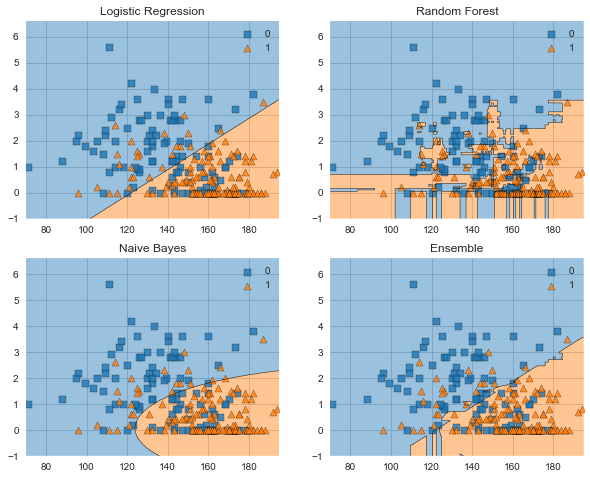

In [14]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,1])
value=1.5
width=0.75
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=(10,8))
labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Ensemble']
for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         labels,
                         itertools.product([0, 1], repeat=2)):
                         
    clf.fit(X_train_ml, y_train_ml)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_ml, y=y_train_ml, clf=clf)
    plt.title(lab)